In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn
import scipy as sp
from PIL import Image


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask is not None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split is not None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [6]:
dfchurn=pd.read_csv("churn.csv")
dfchurn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'

In [8]:
colswewant_cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
colswewant_cat=[u"Int'l Plan", u'VMail Plan']

In [9]:
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

In [10]:
admin_cost=3
offer_cost=100
clv=1000#customer lifetime value

In [11]:
conv=0.5 # Conversion Factor
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*offer_cost + (1. - conv)*(clv+admin_cost)

In [12]:
cost=np.array([[tnc,fpc],[fnc, tpc]])
print(cost)

[[   0.   103. ]
 [1000.   551.5]]


In [13]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

In [14]:
churntrain, churntest = train_test_split(range(dfchurn.shape[0]), train_size=0.6)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

array([ True, False, False, ..., False, False,  True])

In [15]:
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

In [16]:
testsize = dfchurn[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(testchurners, ypred_dste))

[[1132    0]
 [ 202    0]]


In [17]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

151.42428785607197

In [18]:
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(testchurners, ypred_ste))

[[   0 1132]
 [   0  202]]


In [19]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

170.91379310344828

# Naive Bayes Classifier

In [20]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", mask=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.85
[[1032  100]
 [  98  104]]
########################################################


In [21]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1032,  100],
       [  98,  104]], dtype=int64)

In [22]:
average_cost(ytest, clfgnb.predict(Xtest), cost)

124.17991004497752

In [23]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [24]:
average_cost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

115.66041979010495

(array([885., 138.,  46.,  31.,  30.,  21.,  14.,  21.,  13., 135.]),
 array([8.63009170e-05, 1.00077669e-01, 2.00069038e-01, 3.00060406e-01,
        4.00051775e-01, 5.00043143e-01, 6.00034512e-01, 7.00025880e-01,
        8.00017249e-01, 9.00008617e-01, 9.99999985e-01]),
 <a list of 10 Patch objects>)

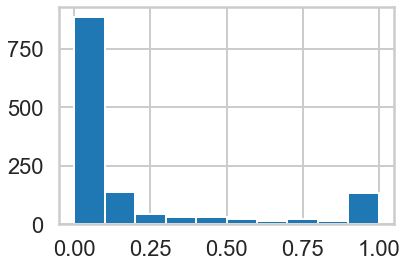

In [25]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

**ROC Value**

In [26]:
from sklearn.metrics import roc_curve, auc

In [27]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

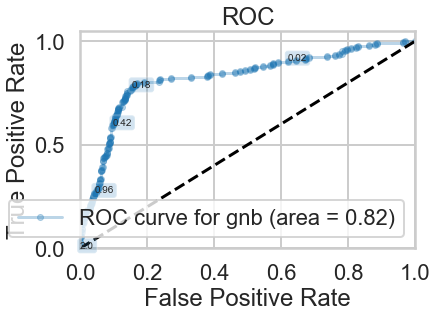

In [28]:
make_roc("gnb",clfgnb, ytest, Xtest, None, labe=50)

**Classifier Comparision**

**Decision Trees**

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [31]:
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, {"max_depth": range(1,10,1)}, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", reuse_split=reuse_split)

using reuse split
BEST {'max_depth': 6} 0.9424712356178089 {'mean_fit_time': array([0.00655951, 0.01345377, 0.00962601, 0.01430063, 0.01638803,
       0.02060227, 0.01924138, 0.02501717, 0.02670903]), 'std_fit_time': array([0.00191791, 0.00548755, 0.00097257, 0.00514336, 0.00225661,
       0.00302848, 0.00069562, 0.0090241 , 0.00770283]), 'mean_score_time': array([0.00060315, 0.0019073 , 0.00079746, 0.00102262, 0.        ,
       0.00040889, 0.        , 0.        , 0.        ]), 'std_score_time': array([0.00060809, 0.00073765, 0.00039874, 0.00159391, 0.        ,
       0.00050078, 0.        , 0.        , 0.        ]), 'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 1}, {'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}, {

In [32]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1114,   18],
       [  74,  128]], dtype=int64)

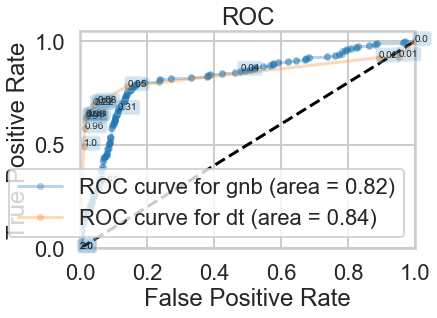

In [33]:
ax=make_roc("gnb",clfgnb, ytest, Xtest, None, labe=60)
make_roc("dt",clfdt, ytest, Xtest, ax, labe=1)

In [34]:
cost

array([[   0. ,  103. ],
       [1000. ,  551.5]])

In [35]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [36]:
def c_repredict(est, c, xtest):
    r = rat(c)
    print(r)
    t=r/(1.+r)
    print("t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [37]:
average_cost(ytest, c_repredict(clfdt, cost, Xtest), cost)

0.22965440356744704
t= 0.18676337262012693


108.06146926536732

In [38]:
print(rat(cost))
slope = rat(cost)*(np.mean(ytest==0)/np.mean(ytest==1))
slope

0.22965440356744704


1.2869741823680696

In [39]:
z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("gnb",clfgnb, ytest, Xtest, ax, labe=60)
    make_roc("dt",clfdt, ytest, Xtest, ax, labe=1)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

In [40]:
from IPython.html.widgets import interact, fixed
interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02))

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=0.5, description='intercept', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.plot_line(ax, intercept)>

In [41]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

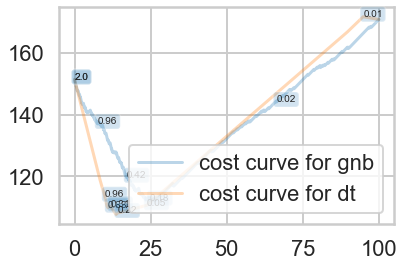

In [42]:
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True, labe=50)
plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=2)

In [43]:
cost

array([[   0. ,  103. ],
       [1000. ,  551.5]])

The above graph is a snapshot of a run. One thing worth noticing is that classifiers perform differently in different regions. If you targeted only the top 20% of your users..and these are the ones most likely to churn so you should target them first, you would want to use the decision-tree classifier. And you might only get to target these top 20 given your budget. Remember that there is a cost associated with targeting predicted positives. That cost can be read of the graph above. Say we had a million customers. Now, at 10%, or 100,000 we are talking about a minimum budget of 10.3 million dollars.

If 10-15 million is your budget, then you use the decision tree classifier on your left. If 40-60 million is your budget, roughly, you would use the gnb classifier instead.